In [ ]:
# Cell 1: Install required libraries (conflict-free versions)
!pip install torch==2.1.0 torchvision==0.16.0 -q
!pip install transformers==4.35.0 -q
!pip install datasets==2.14.6 -q
!pip install Pillow==10.1.0 -q
!pip install matplotlib==3.8.0 seaborn==0.13.0 -q
!pip install scikit-learn==1.3.2 -q
!pip install accelerate==0.24.1 -q
!pip install gradio==4.7.1 -q

In [ ]:
# Cell 1: Install required libraries with conflict resolution
import sys

# First, upgrade pip
!{sys.executable} -m pip install --upgrade pip -q

# Install PyTorch and torchvision
print("Installing PyTorch and torchvision...")
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118 -q

# Fix pyarrow and datasets compatibility
print("Fixing pyarrow and datasets compatibility...")
!pip uninstall pyarrow datasets -y -q
!pip install pyarrow==14.0.1 -q
!pip install datasets==2.14.6 -q

# Install transformers and other requirements
print("Installing transformers and other libraries...")
!pip install transformers==4.35.0 -q
!pip install accelerate==0.24.1 -q
!pip install scikit-learn matplotlib seaborn Pillow -q

print("\n✓ All packages installed successfully!")

In [2]:
# Cell 2: Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("tab10")

print("="*60)
print("ENVIRONMENT SETUP COMPLETE")
print("="*60)
print(f"✓ All libraries imported successfully!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*60)

ENVIRONMENT SETUP COMPLETE
✓ All libraries imported successfully!
✓ PyTorch version: 2.6.0+cu124
✓ CUDA available: True
✓ GPU: Tesla T4
✓ GPU Memory: 14.74 GB


In [7]:
# Cell 3: Set up dataset paths and explore structure
dataset_path = '/kaggle/input/food41/images'  # Correct path to images folder

# Check if path exists
if not os.path.exists(dataset_path):
    print(f"Error: Path {dataset_path} does not exist!")
else:
    print(f"Dataset path found: {dataset_path}")

# List all categories (subdirectories)
categories = []
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        categories.append(item)

categories = sorted(categories)

print(f"\n{'='*60}")
print(f"Number of food categories: {len(categories)}")
print(f"{'='*60}")
print("\nFood Categories:")
for i, cat in enumerate(categories, 1):
    print(f"{i:3d}. {cat.replace('_', ' ').title()}")

Dataset path found: /kaggle/input/food41/images

Number of food categories: 101

Food Categories:
  1. Apple Pie
  2. Baby Back Ribs
  3. Baklava
  4. Beef Carpaccio
  5. Beef Tartare
  6. Beet Salad
  7. Beignets
  8. Bibimbap
  9. Bread Pudding
 10. Breakfast Burrito
 11. Bruschetta
 12. Caesar Salad
 13. Cannoli
 14. Caprese Salad
 15. Carrot Cake
 16. Ceviche
 17. Cheese Plate
 18. Cheesecake
 19. Chicken Curry
 20. Chicken Quesadilla
 21. Chicken Wings
 22. Chocolate Cake
 23. Chocolate Mousse
 24. Churros
 25. Clam Chowder
 26. Club Sandwich
 27. Crab Cakes
 28. Creme Brulee
 29. Croque Madame
 30. Cup Cakes
 31. Deviled Eggs
 32. Donuts
 33. Dumplings
 34. Edamame
 35. Eggs Benedict
 36. Escargots
 37. Falafel
 38. Filet Mignon
 39. Fish And Chips
 40. Foie Gras
 41. French Fries
 42. French Onion Soup
 43. French Toast
 44. Fried Calamari
 45. Fried Rice
 46. Frozen Yogurt
 47. Garlic Bread
 48. Gnocchi
 49. Greek Salad
 50. Grilled Cheese Sandwich
 51. Grilled Salmon
 52. Guac

In [8]:
# Cell 4: Count images in each category
print("Counting images in each category...\n")

image_counts = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Count image files
    images = [f for f in os.listdir(category_path) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_counts[category] = len(images)

# Create a dataframe for better visualization
df_counts = pd.DataFrame(list(image_counts.items()), 
                         columns=['Category', 'Image_Count'])
df_counts = df_counts.sort_values('Image_Count', ascending=False)

print("Images per category:")
print(df_counts.to_string(index=False))
print(f"\n{'='*60}")
print(f"Total images in dataset: {df_counts['Image_Count'].sum()}")
print(f"{'='*60}")

Counting images in each category...

Images per category:
               Category  Image_Count
                waffles         1000
              apple_pie         1000
         baby_back_ribs         1000
                baklava         1000
         beef_carpaccio         1000
                 samosa         1000
                sashimi         1000
               scallops         1000
          seaweed_salad         1000
       shrimp_and_grits         1000
    spaghetti_bolognese         1000
    spaghetti_carbonara         1000
           spring_rolls         1000
          caprese_salad         1000
            carrot_cake         1000
                ceviche         1000
           cheese_plate         1000
             cheesecake         1000
          chicken_curry         1000
     chicken_quesadilla         1000
          chicken_wings         1000
         chocolate_cake         1000
       chocolate_mousse         1000
                churros         1000
           clam_c

Displaying sample images from 6 random categories...



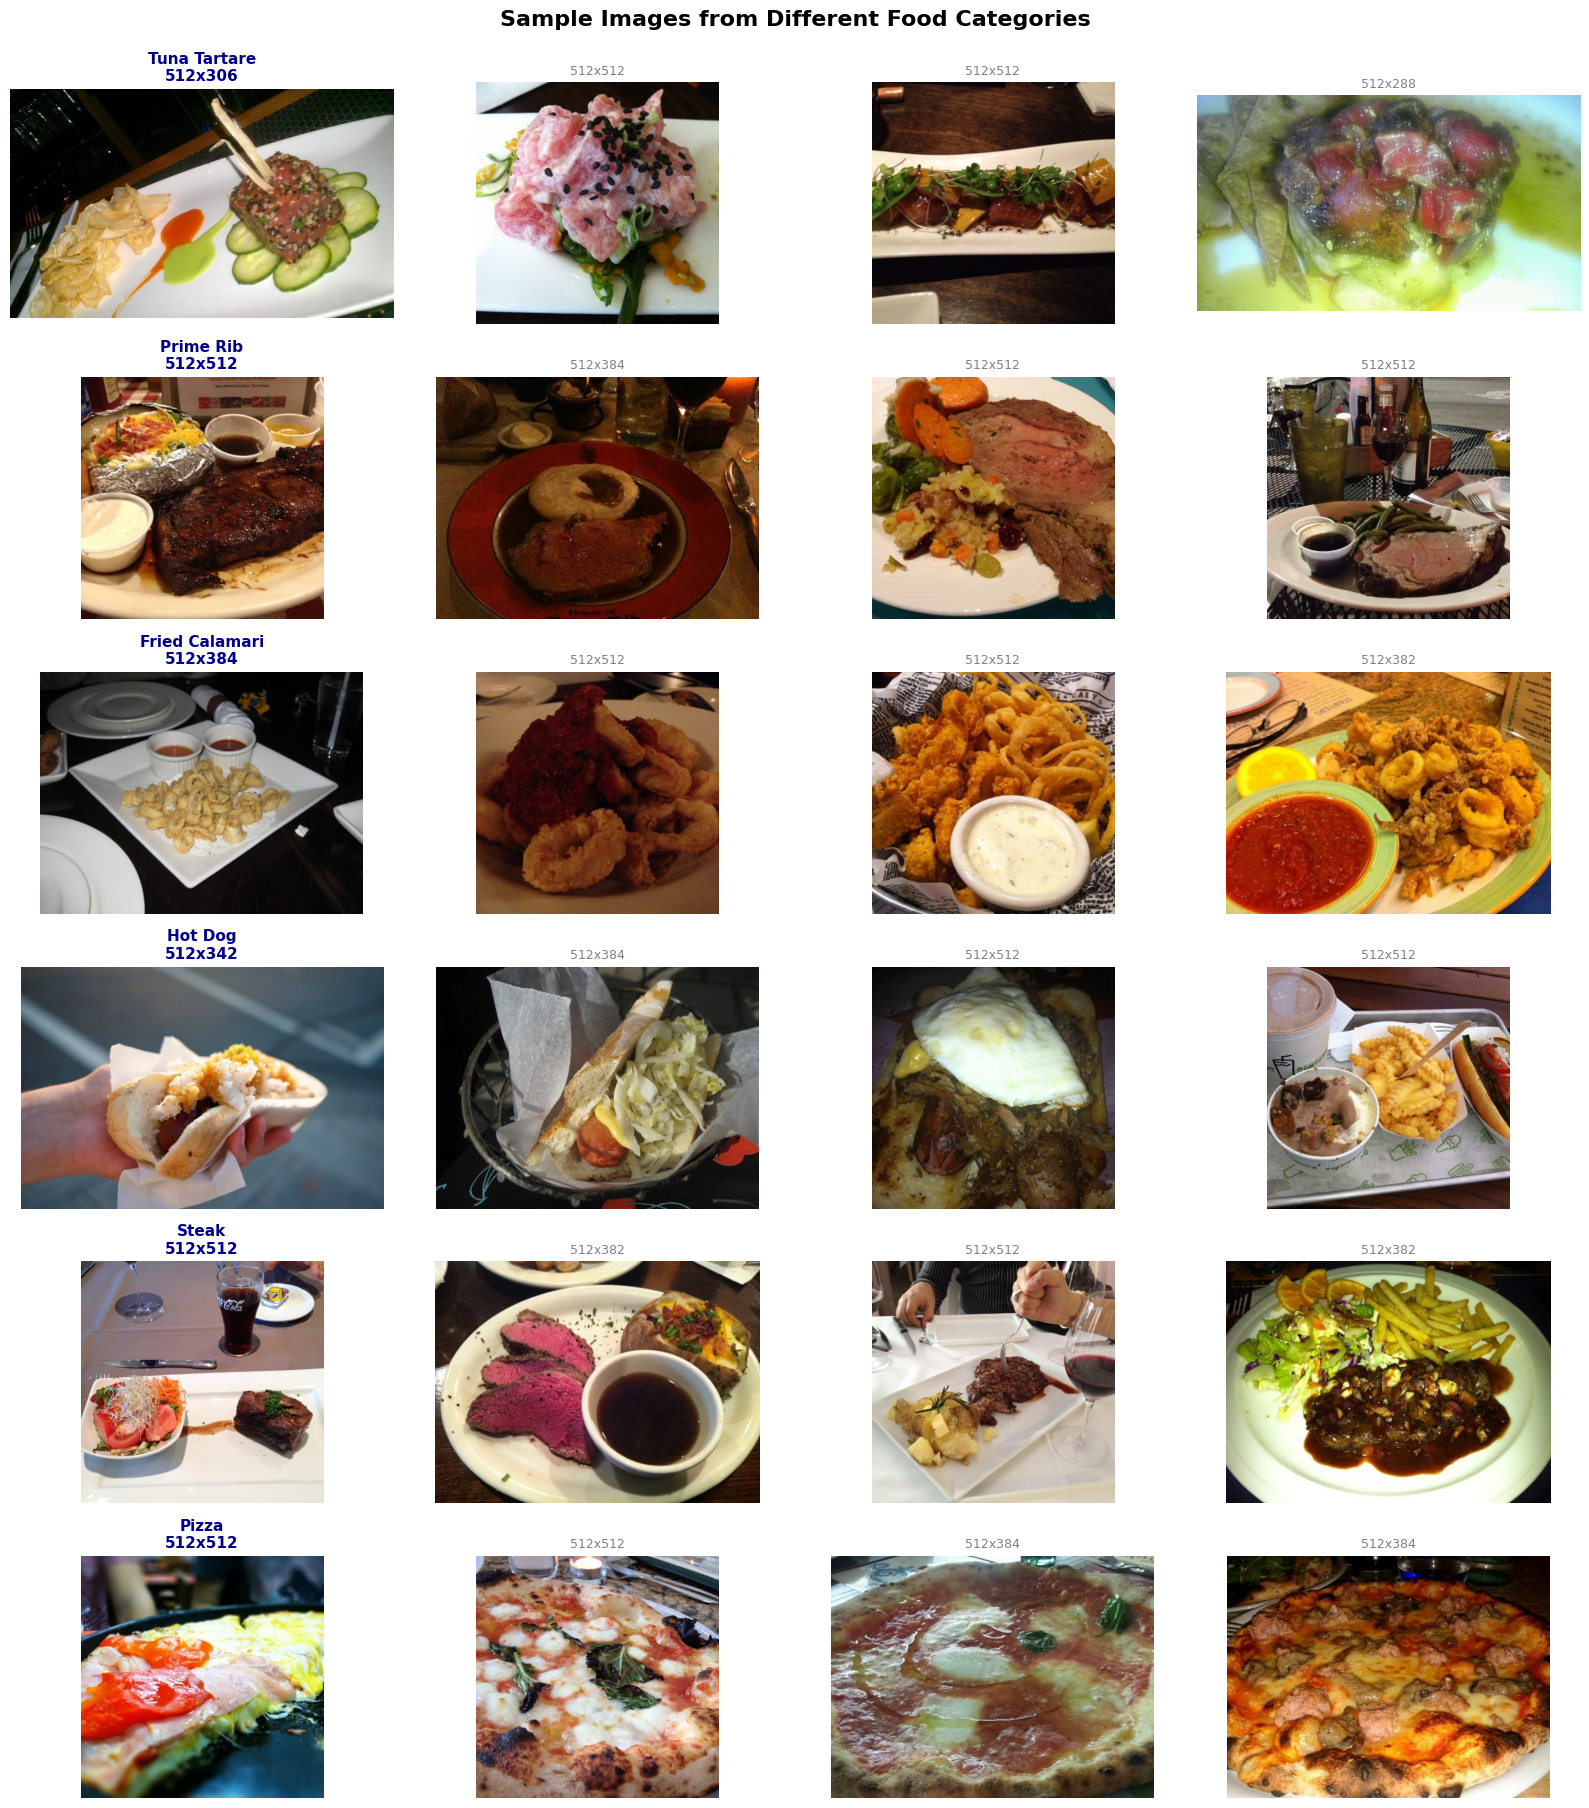

In [9]:
# Cell 6: Display sample images from random categories
import random

def display_sample_images(num_categories=6, images_per_category=4):
    """Display sample images from random categories"""
    
    # Randomly select categories
    sample_categories = random.sample(categories, min(num_categories, len(categories)))
    
    fig, axes = plt.subplots(num_categories, images_per_category, 
                            figsize=(16, 3*num_categories))
    
    if num_categories == 1:
        axes = axes.reshape(1, -1)
    
    for i, category in enumerate(sample_categories):
        category_path = os.path.join(dataset_path, category)
        image_files = [f for f in os.listdir(category_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Randomly select images
        sample_images = random.sample(image_files, 
                                     min(images_per_category, len(image_files)))
        
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                if j == 0:
                    axes[i, j].set_title(f"{category.replace('_', ' ').title()}\n{img.size[0]}x{img.size[1]}", 
                                       fontsize=11, fontweight='bold', color='darkblue')
                else:
                    axes[i, j].set_title(f"{img.size[0]}x{img.size[1]}", 
                                       fontsize=9, color='gray')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, 'Error loading image', 
                              ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.suptitle('Sample Images from Different Food Categories', 
                 fontsize=16, fontweight='bold', y=1.002)
    plt.tight_layout()
    plt.show()

# Display samples
print("Displaying sample images from 6 random categories...\n")
display_sample_images(num_categories=6, images_per_category=4)

In [10]:
# Cell 7: Analyze image dimensions across the dataset
from collections import Counter

def analyze_image_dimensions(sample_size=1000):
    """Analyze dimensions of a sample of images"""
    
    dimensions = []
    aspect_ratios = []
    file_sizes = []
    
    # Sample images from different categories
    images_per_category = sample_size // len(categories)
    
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_files = [f for f in os.listdir(category_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        sample = random.sample(image_files, 
                              min(images_per_category, len(image_files)))
        
        for img_file in sample:
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path)
                width, height = img.size
                dimensions.append((width, height))
                aspect_ratios.append(width / height)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
            except Exception as e:
                continue
    
    return dimensions, aspect_ratios, file_sizes

print("Analyzing image dimensions and properties...")
print("(Sampling 1000 images from the dataset...)\n")

dimensions, aspect_ratios, file_sizes = analyze_image_dimensions(sample_size=1000)

# Display results
widths = [d[0] for d in dimensions]
heights = [d[1] for d in dimensions]

print("="*60)
print("IMAGE DIMENSION ANALYSIS")
print("="*60)
print(f"Total images analyzed: {len(dimensions)}")
print(f"\nWidth Statistics:")
print(f"  Min:  {min(widths):>6} pixels")
print(f"  Max:  {max(widths):>6} pixels")
print(f"  Mean: {np.mean(widths):>6.2f} pixels")
print(f"  Std:  {np.std(widths):>6.2f} pixels")

print(f"\nHeight Statistics:")
print(f"  Min:  {min(heights):>6} pixels")
print(f"  Max:  {max(heights):>6} pixels")
print(f"  Mean: {np.mean(heights):>6.2f} pixels")
print(f"  Std:  {np.std(heights):>6.2f} pixels")

print(f"\nAspect Ratio Statistics:")
print(f"  Min:  {min(aspect_ratios):>6.2f}")
print(f"  Max:  {max(aspect_ratios):>6.2f}")
print(f"  Mean: {np.mean(aspect_ratios):>6.2f}")

print(f"\nFile Size Statistics:")
print(f"  Min:  {min(file_sizes):>7.2f} KB")
print(f"  Max:  {max(file_sizes):>7.2f} KB")
print(f"  Mean: {np.mean(file_sizes):>7.2f} KB")

# Find most common dimensions
dimension_counts = Counter(dimensions)
print(f"\nMost Common Image Dimensions:")
for dim, count in dimension_counts.most_common(10):
    print(f"  {dim[0]:>4}x{dim[1]:<4}: {count:>3} images")
print("="*60)

Analyzing image dimensions and properties...
(Sampling 1000 images from the dataset...)

IMAGE DIMENSION ANALYSIS
Total images analyzed: 909

Width Statistics:
  Min:     288 pixels
  Max:     512 pixels
  Mean: 497.26 pixels
  Std:   44.28 pixels

Height Statistics:
  Min:     287 pixels
  Max:     512 pixels
  Mean: 474.58 pixels
  Std:   66.14 pixels

Aspect Ratio Statistics:
  Min:    0.56
  Max:    1.78
  Mean:   1.08

File Size Statistics:
  Min:    17.97 KB
  Max:   140.73 KB
  Mean:   50.12 KB

Most Common Image Dimensions:
   512x512 : 563 images
   512x384 : 136 images
   384x512 :  47 images
   382x512 :  22 images
   512x382 :  18 images
   512x341 :  11 images
   511x512 :  10 images
   306x512 :  10 images
   512x288 :  10 images
   512x289 :   8 images


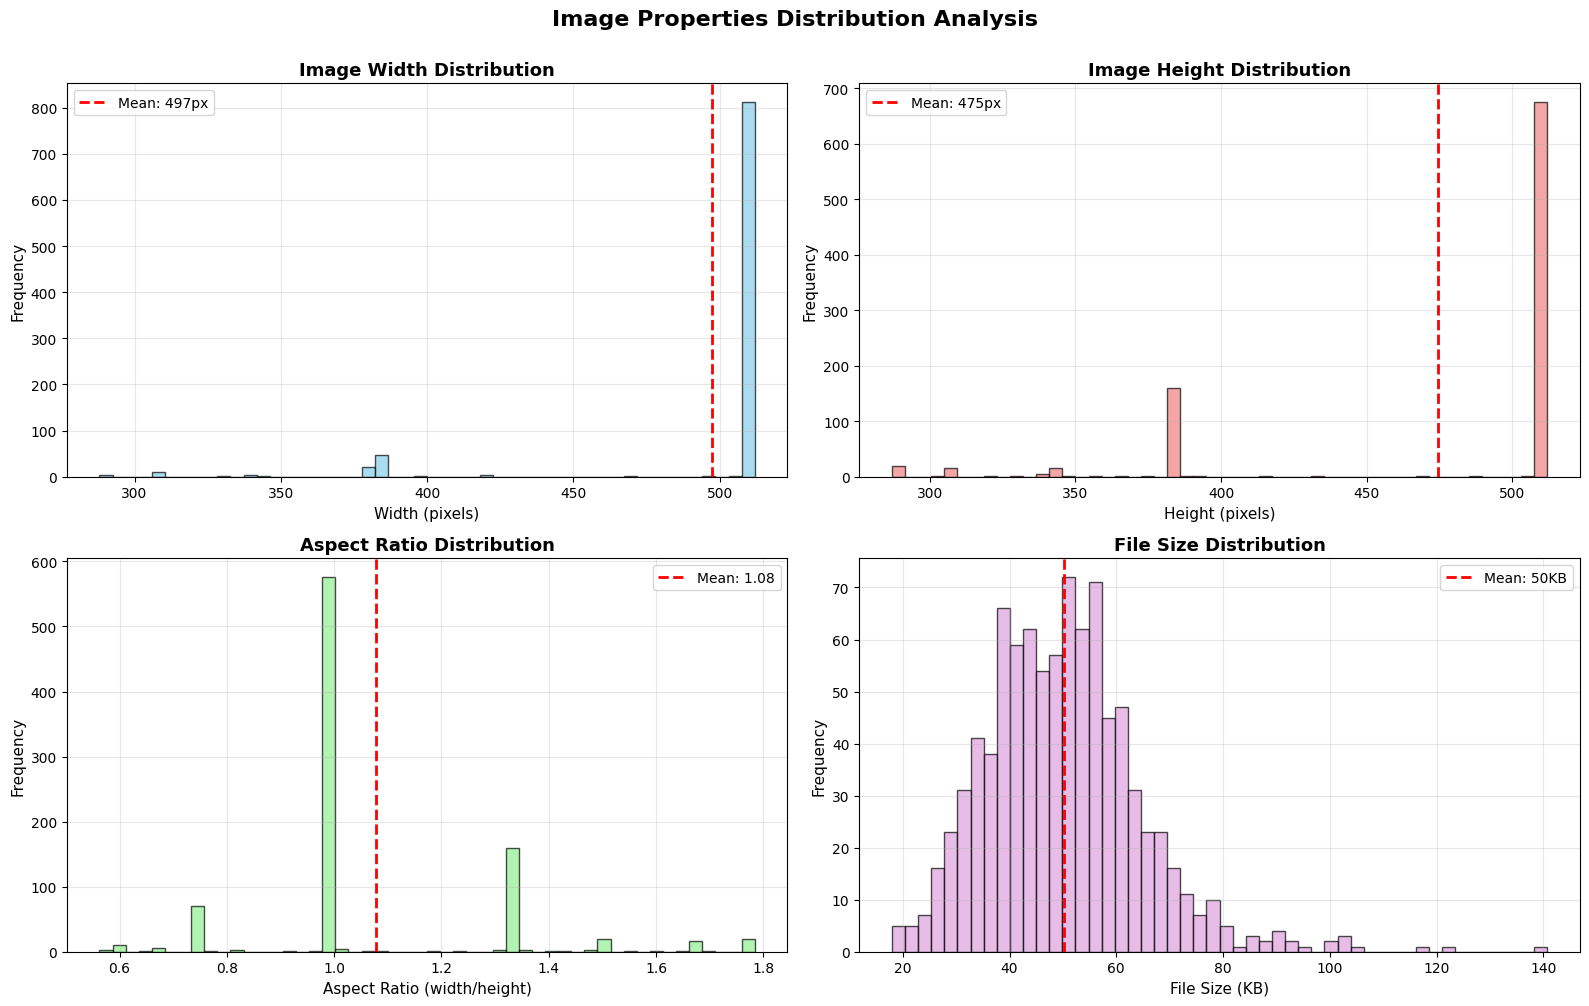

In [11]:
# Cell 8: Visualize dimension distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Width distribution
axes[0, 0].hist(widths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Width (pixels)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Image Width Distribution', fontsize=13, fontweight='bold')
axes[0, 0].axvline(np.mean(widths), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(widths):.0f}px')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(heights, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Height (pixels)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Image Height Distribution', fontsize=13, fontweight='bold')
axes[0, 1].axvline(np.mean(heights), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(heights):.0f}px')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(aspect_ratios, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Aspect Ratio (width/height)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=13, fontweight='bold')
axes[1, 0].axvline(np.mean(aspect_ratios), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# File size distribution
axes[1, 1].hist(file_sizes, bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('File Size (KB)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('File Size Distribution', fontsize=13, fontweight='bold')
axes[1, 1].axvline(np.mean(file_sizes), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(file_sizes):.0f}KB')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Image Properties Distribution Analysis', 
             fontsize=16, fontweight='bold', y=1.002)
plt.tight_layout()
plt.show()

In [12]:
# Cell 9: Create label mappings for the model
# Create id2label and label2id dictionaries
id2label = {i: category for i, category in enumerate(sorted(categories))}
label2id = {category: i for i, category in id2label.items()}

print("="*60)
print("LABEL MAPPINGS CREATED")
print("="*60)
print(f"Total classes: {len(id2label)}")
print("\nComplete Label Mappings:")
print("-" * 60)

# Display in a formatted table
for i in range(len(id2label)):
    print(f"ID {i:3d} → {id2label[i].replace('_', ' ').title():<30} | {label2id[id2label[i]]:3d}")

print("="*60)
print(f"✓ id2label dictionary: {len(id2label)} categories")
print(f"✓ label2id dictionary: {len(label2id)} categories")
print("="*60)

# Save to file for reference
import json
with open('label_mappings.json', 'w') as f:
    json.dump({'id2label': id2label, 'label2id': label2id}, f, indent=2)
print("\n✓ Label mappings saved to 'label_mappings.json'")

LABEL MAPPINGS CREATED
Total classes: 101

Complete Label Mappings:
------------------------------------------------------------
ID   0 → Apple Pie                      |   0
ID   1 → Baby Back Ribs                 |   1
ID   2 → Baklava                        |   2
ID   3 → Beef Carpaccio                 |   3
ID   4 → Beef Tartare                   |   4
ID   5 → Beet Salad                     |   5
ID   6 → Beignets                       |   6
ID   7 → Bibimbap                       |   7
ID   8 → Bread Pudding                  |   8
ID   9 → Breakfast Burrito              |   9
ID  10 → Bruschetta                     |  10
ID  11 → Caesar Salad                   |  11
ID  12 → Cannoli                        |  12
ID  13 → Caprese Salad                  |  13
ID  14 → Carrot Cake                    |  14
ID  15 → Ceviche                        |  15
ID  16 → Cheese Plate                   |  16
ID  17 → Cheesecake                     |  17
ID  18 → Chicken Curry                  |  

In [13]:
# Cell 10: Import required libraries for preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import numpy as np

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [14]:
# Cell 11: Define custom dataset class
class FoodDataset(Dataset):
    """Custom Dataset for Food-101 images"""
    
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of image file paths
            labels (list): List of corresponding labels
            transform (callable, optional): Optional transform to be applied on images
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image if error occurs
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        label = self.labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Custom FoodDataset class defined")

✓ Custom FoodDataset class defined


In [16]:
# Cell 12: Define data transforms for ViT
# ImageNet normalization statistics (ViT was pretrained on ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize(256),                          # Resize to slightly larger
    transforms.RandomResizedCrop(224),               # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),          # Random horizontal flip
    transforms.RandomRotation(degrees=15),           # Random rotation ±15 degrees
    transforms.ColorJitter(                          # Random color adjustments
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=mean, std=std)         # Normalize with ImageNet stats
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize(256),                          # Resize to 256
    transforms.CenterCrop(224),                      # Center crop to 224x224
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=mean, std=std)         # Normalize with ImageNet stats
])

print("="*60)
print("DATA TRANSFORMS DEFINED")
print("="*60)
print("\nTraining Transforms (with augmentation):")
print("  1. Resize to 256x256")
print("  2. Random Resized Crop to 224x224")
print("  3. Random Horizontal Flip (50%)")
print("  4. Random Rotation (±15°)")
print("  5. Color Jitter (brightness, contrast, saturation, hue)")
print("  6. Convert to Tensor")
print("  7. Normalize with ImageNet statistics")

print("\nValidation/Test Transforms (no augmentation):")
print("  1. Resize to 256x256")
print("  2. Center Crop to 224x224")
print("  3. Convert to Tensor")
print("  4. Normalize with ImageNet statistics")
print("="*60)








DATA TRANSFORMS DEFINED

Training Transforms (with augmentation):
  1. Resize to 256x256
  2. Random Resized Crop to 224x224
  3. Random Horizontal Flip (50%)
  4. Random Rotation (±15°)
  5. Color Jitter (brightness, contrast, saturation, hue)
  6. Convert to Tensor
  7. Normalize with ImageNet statistics

Validation/Test Transforms (no augmentation):
  1. Resize to 256x256
  2. Center Crop to 224x224
  3. Convert to Tensor
  4. Normalize with ImageNet statistics


In [17]:
# Cell 13: Prepare dataset - collect all image paths and labels
print("\nCollecting all image paths and labels...")

all_image_paths = []
all_labels = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    label = label2id[category]  # Get numeric label
    
    # Get all image files in this category
    image_files = [f for f in os.listdir(category_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Create full paths
    for img_file in image_files:
        img_path = os.path.join(category_path, img_file)
        all_image_paths.append(img_path)
        all_labels.append(label)

print(f"✓ Collected {len(all_image_paths)} images")
print(f"✓ Labels range from {min(all_labels)} to {max(all_labels)}")


# Cell 14: Split dataset into train, validation, and test sets
# First split: 85% train+val, 15% test
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_image_paths, 
    all_labels, 
    test_size=0.15, 
    random_state=42,
    stratify=all_labels  # Maintain class distribution
)

# Second split: 82.35% train (70% of total), 17.65% val (15% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 (15% of total)
    random_state=42,
    stratify=train_val_labels
)

print("="*60)
print("DATASET SPLIT COMPLETED")
print("="*60)
print(f"Total images:      {len(all_image_paths):>6}")
print(f"Training set:      {len(train_paths):>6} ({len(train_paths)/len(all_image_paths)*100:.1f}%)")
print(f"Validation set:    {len(val_paths):>6} ({len(val_paths)/len(all_image_paths)*100:.1f}%)")
print(f"Test set:          {len(test_paths):>6} ({len(test_paths)/len(all_image_paths)*100:.1f}%)")
print("="*60)

# Verify class distribution
print("\nVerifying class distribution in splits:")
print(f"Training - Unique classes:   {len(set(train_labels))}")
print(f"Validation - Unique classes: {len(set(val_labels))}")
print(f"Test - Unique classes:       {len(set(test_labels))}")
print("="*60)


✓ Collected 101000 images
✓ Labels range from 0 to 100
DATASET SPLIT COMPLETED
Total images:      101000
Training set:       70740 (70.0%)
Validation set:     15110 (15.0%)
Test set:           15150 (15.0%)

Verifying class distribution in splits:
Training - Unique classes:   101
Validation - Unique classes: 101
Test - Unique classes:       101


In [18]:
# Cell 15: Create PyTorch datasets
train_dataset = FoodDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = FoodDataset(val_paths, val_labels, transform=val_transforms)
test_dataset = FoodDataset(test_paths, test_labels, transform=val_transforms)

print("\n✓ PyTorch datasets created:")
print(f"  - Training dataset:   {len(train_dataset)} samples")
print(f"  - Validation dataset: {len(val_dataset)} samples")
print(f"  - Test dataset:       {len(test_dataset)} samples")


✓ PyTorch datasets created:
  - Training dataset:   70740 samples
  - Validation dataset: 15110 samples
  - Test dataset:       15150 samples


In [19]:
# Cell 16: Create DataLoaders
# Adjust batch size based on available GPU memory
BATCH_SIZE = 32  # Can adjust: 16, 32, 64 depending on GPU

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle training data
    num_workers=2,          # Parallel data loading
    pin_memory=True         # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle validation data
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle test data
    num_workers=2,
    pin_memory=True
)

print("="*60)
print("DATALOADERS CREATED")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")
print(f"\nTraining batches:   {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches:       {len(test_loader)}")
print("="*60)


DATALOADERS CREATED
Batch size: 32

Training batches:   2211
Validation batches: 473
Test batches:       474


In [20]:
# Cell 17: Test data loading and visualize sample batch
print("\nTesting data loading...")

# Get a sample batch
sample_images, sample_labels = next(iter(train_loader))

print(f"\n✓ Successfully loaded a batch!")
print(f"  Batch shape: {sample_images.shape}")
print(f"  Labels shape: {sample_labels.shape}")
print(f"  Image dtype: {sample_images.dtype}")
print(f"  Image value range: [{sample_images.min():.2f}, {sample_images.max():.2f}]")

# Sample some labels from this batch
print(f"\nSample labels from batch (numeric): {sample_labels[:5].tolist()}")
print(f"Sample labels from batch (names): {[id2label[l.item()] for l in sample_labels[:5]]}")

print("\n" + "="*60)
print("DATA PREPROCESSING PIPELINE COMPLETE! ✓")
print("="*60)
print("\nReady for model training!")
print("\nNext steps:")
print("  1. Load pre-trained ViT model")
print("  2. Configure training parameters")
print("  3. Train the model")
print("  4. Evaluate on test set")
print("="*60)


Testing data loading...

✓ Successfully loaded a batch!
  Batch shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Image dtype: torch.float32
  Image value range: [-2.12, 2.64]

Sample labels from batch (numeric): [99, 61, 35, 79, 8]
Sample labels from batch (names): ['tuna_tartare', 'lobster_roll_sandwich', 'escargots', 'prime_rib', 'bread_pudding']

DATA PREPROCESSING PIPELINE COMPLETE! ✓

Ready for model training!

Next steps:
  1. Load pre-trained ViT model
  2. Configure training parameters
  3. Train the model
  4. Evaluate on test set


In [21]:
# Cell 18: Install and import transformers library
# Run this if transformers is not installed
# !pip install transformers -q

from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

print("✓ Transformers library imported successfully")

✓ Transformers library imported successfully


In [22]:
# Cell 19: Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*60)
print("DEVICE CONFIGURATION")
print("="*60)
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("WARNING: No GPU available, training will be slow!")
print("="*60)

DEVICE CONFIGURATION
Device: cuda
GPU Name: Tesla T4
GPU Memory: 14.74 GB
CUDA Version: 12.4


In [23]:
# Cell 20: Load pre-trained ViT model
print("\nLoading pre-trained ViT model...")
print("Model: google/vit-base-patch16-224")
model_name = "google/vit-base-patch16-224"
# Load model with custom number of labels
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=101,           # Our dataset has 101 classes
    id2label=id2label,        # Label mappings we created
    label2id=label2id,
    ignore_mismatched_sizes=True  # Allow classifier head resize
)
# Move model to GPU
model = model.to(device)
print("✓ Model loaded successfully!")
print(f"✓ Model moved to {device}")
# Display model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size:           ~{total_params * 4 / 1024**2:.2f} MB")


Loading pre-trained ViT model...
Model: google/vit-base-patch16-224


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!
✓ Model moved to cuda

Model Statistics:
  Total parameters:     85,876,325
  Trainable parameters: 85,876,325
  Model size:           ~327.59 MB


In [24]:

# Cell 21: Configure training parameters
print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
# Hyperparameters
NUM_EPOCHS = 3              # Start with 3 epochs (increase to 5 if needed)
LEARNING_RATE = 2e-5        # Small learning rate for fine-tuning
WEIGHT_DECAY = 0.01         # L2 regularization
WARMUP_STEPS = 500          # Learning rate warmup
GRADIENT_ACCUMULATION = 2   # Accumulate gradients (effective batch size = 32*2=64)
PATIENCE = 3                # Early stopping patience
MIN_DELTA = 0.001           # Minimum change to qualify as improvement
print(f"Number of epochs:          {NUM_EPOCHS}")
print(f"Learning rate:             {LEARNING_RATE}")
print(f"Weight decay:              {WEIGHT_DECAY}")
print(f"Warmup steps:              {WARMUP_STEPS}")
print(f"Gradient accumulation:     {GRADIENT_ACCUMULATION}")
print(f"Effective batch size:      {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"Early stopping patience:   {PATIENCE} epochs")
print(f"Minimum delta:             {MIN_DELTA}")
print("="*60)


TRAINING CONFIGURATION
Number of epochs:          3
Learning rate:             2e-05
Weight decay:              0.01
Warmup steps:              500
Gradient accumulation:     2
Effective batch size:      64
Early stopping patience:   3 epochs
Minimum delta:             0.001


In [25]:

# Cell 22: Setup optimizer and scheduler
# Optimizer - AdamW with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
# Calculate total training steps
total_steps = len(train_loader) * NUM_EPOCHS // GRADIENT_ACCUMULATION
# Learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)
# Loss function (CrossEntropyLoss is built into the model)
print(f"\n✓ Optimizer: AdamW")
print(f"✓ Scheduler: Linear with warmup")
print(f"✓ Total training steps: {total_steps}")
print(f"✓ Loss function: CrossEntropyLoss (built-in)")


✓ Optimizer: AdamW
✓ Scheduler: Linear with warmup
✓ Total training steps: 3316
✓ Loss function: CrossEntropyLoss (built-in)


In [26]:
# Cell 23: Define training function
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch, gradient_accumulation=1):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    optimizer.zero_grad()
    
    # Progress tracking
    total_batches = len(dataloader)
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss
        
        # Backward pass with gradient accumulation
        loss = loss / gradient_accumulation
        loss.backward()
        
        # Update weights after accumulation steps
        if (batch_idx + 1) % gradient_accumulation == 0:
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Accumulate loss
        total_loss += loss.item() * gradient_accumulation
        
        # Print progress every 50 batches with percentage
        if (batch_idx + 1) % 50 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = 100 * correct / total
            progress = 100 * (batch_idx + 1) / total_batches
            print(f"  Progress: {progress:.1f}% | Batch [{batch_idx+1}/{total_batches}] | "
                  f"Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}%")
    
    epoch_loss = total_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("\n✓ Training function defined")



✓ Training function defined


In [27]:

# Cell 24: Define validation function
def validate(model, dataloader, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(pixel_values=images, labels=labels)
            loss = outputs.loss
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                progress = 100 * (batch_idx + 1) / len(dataloader)
                print(f"  Progress: {progress:.1f}% | Batch [{batch_idx+1}/{len(dataloader)}]")
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("✓ Validation function defined")

✓ Validation function defined


In [28]:

# Cell 25: Training history tracking
training_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}
print("\n✓ Training history tracker initialized")
print("\n" + "="*60)
print("MODEL SETUP COMPLETE! ✓")
print("="*60)
print("\nReady to start training!")
print("\nNext step: Run the training loop (Cell 26)")
print("="*60)



✓ Training history tracker initialized

MODEL SETUP COMPLETE! ✓

Ready to start training!

Next step: Run the training loop (Cell 26)


In [30]:

# Cell 26: Main training loop with checkpoints and early stopping
import time
from datetime import datetime
import os

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

print("="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training on: {device}")
print(f"Total epochs: {NUM_EPOCHS}")
print(f"Checkpoints will be saved in: ./checkpoints/")
print("="*60)

# Track best validation accuracy and loss for model saving
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Training phase
    print("\n[Training Phase]")
    train_loss, train_acc = train_epoch(
        model, 
        train_loader, 
        optimizer, 
        scheduler, 
        device, 
        epoch,
        gradient_accumulation=GRADIENT_ACCUMULATION
    )
    
    # Validation phase
    print("\n[Validation Phase]")
    val_loss, val_acc = validate(model, val_loader, device)
    
    # Save training history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch summary
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch + 1} SUMMARY")
    print(f"{'='*60}")
    print(f"Training Loss:       {train_loss:.4f}")
    print(f"Training Accuracy:   {train_acc:.2f}%")
    print(f"Validation Loss:     {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Epoch Time:          {epoch_time/60:.2f} minutes")
    print(f"{'='*60}")
    
    # Save checkpoint for every epoch
    checkpoint_path = f'checkpoints/checkpoint_epoch_{epoch+1}.pth'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'training_history': training_history,
    }, checkpoint_path)
    print(f"✓ Checkpoint saved: {checkpoint_path}")
    
    # Check if this is the best model (based on validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        epochs_no_improve = 0
        
        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'training_history': training_history,
        }, 'best_vit_food_model.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        epochs_no_improve += 1
        print(f"⚠ No improvement for {epochs_no_improve} epoch(s)")
    
    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"No improvement in validation accuracy for {PATIENCE} consecutive epochs")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        print(f"{'='*60}")
        break
    
    # Print overall progress
    elapsed_time = time.time() - training_start_time
    estimated_total = (elapsed_time / (epoch + 1)) * NUM_EPOCHS
    remaining_time = estimated_total - elapsed_time
    
    print(f"\nOverall Progress: {((epoch+1)/NUM_EPOCHS)*100:.1f}%")
    print(f"Elapsed Time: {elapsed_time/3600:.2f} hours")
    print(f"Estimated Remaining: {remaining_time/3600:.2f} hours")

# Calculate total training time
total_training_time = time.time() - training_start_time

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total training time: {total_training_time/3600:.2f} hours")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Total epochs completed: {epoch + 1}")
print(f"Best model saved as: best_vit_food_model.pth")
print(f"Checkpoints saved in: ./checkpoints/")
print("="*60)

# Print training history summary
print("\n" + "="*60)
print("TRAINING HISTORY SUMMARY")
print("="*60)
for i, (tl, ta, vl, va) in enumerate(zip(
    training_history['train_loss'],
    training_history['train_acc'],
    training_history['val_loss'],
    training_history['val_acc']
), 1):
    print(f"Epoch {i}: Train Loss={tl:.4f}, Train Acc={ta:.2f}%, "
          f"Val Loss={vl:.4f}, Val Acc={va:.2f}%")
print("="*60)

STARTING TRAINING
Start time: 2025-11-03 15:16:29
Training on: cuda
Total epochs: 3
Checkpoints will be saved in: ./checkpoints/

EPOCH 1/3

[Training Phase]
  Progress: 2.3% | Batch [50/2211] | Loss: 4.4977 | Acc: 3.81%
  Progress: 4.5% | Batch [100/2211] | Loss: 4.4696 | Acc: 4.94%
  Progress: 6.8% | Batch [150/2211] | Loss: 4.4340 | Acc: 5.90%
  Progress: 9.0% | Batch [200/2211] | Loss: 4.3942 | Acc: 7.14%
  Progress: 11.3% | Batch [250/2211] | Loss: 4.3484 | Acc: 8.54%
  Progress: 13.6% | Batch [300/2211] | Loss: 4.2979 | Acc: 10.22%
  Progress: 15.8% | Batch [350/2211] | Loss: 4.2491 | Acc: 11.84%
  Progress: 18.1% | Batch [400/2211] | Loss: 4.1928 | Acc: 13.74%
  Progress: 20.4% | Batch [450/2211] | Loss: 4.1348 | Acc: 15.66%
  Progress: 22.6% | Batch [500/2211] | Loss: 4.0683 | Acc: 17.79%
  Progress: 24.9% | Batch [550/2211] | Loss: 4.0041 | Acc: 19.60%
  Progress: 27.1% | Batch [600/2211] | Loss: 3.9363 | Acc: 21.41%
  Progress: 29.4% | Batch [650/2211] | Loss: 3.8699 | Acc: 2

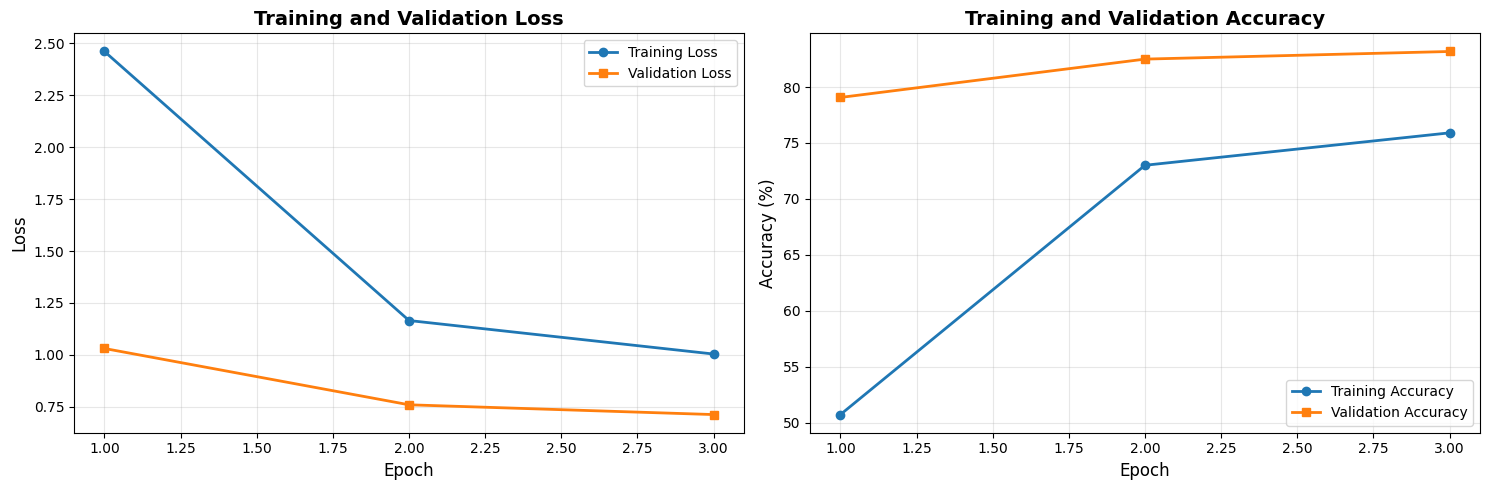

✓ Training curves saved as 'training_history.png'


In [31]:

# Cell 27: Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(range(1, NUM_EPOCHS + 1), training_history['train_loss'], 
             marker='o', label='Training Loss', linewidth=2)
axes[0].plot(range(1, NUM_EPOCHS + 1), training_history['val_loss'], 
             marker='s', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(range(1, NUM_EPOCHS + 1), training_history['train_acc'], 
             marker='o', label='Training Accuracy', linewidth=2)
axes[1].plot(range(1, NUM_EPOCHS + 1), training_history['val_acc'], 
             marker='s', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as 'training_history.png'")

In [32]:

# Cell 28: Load best model and evaluate on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Load best model
checkpoint = torch.load('best_vit_food_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"  (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Evaluate on test set
print("\nRunning evaluation on test set...")
test_loss, test_acc = validate(model, test_loader, device)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*60}")


EVALUATING ON TEST SET
✓ Loaded best model from epoch 4
  (Val Acc: 83.18%)

Running evaluation on test set...
  Progress: 10.5% | Batch [50/474]
  Progress: 21.1% | Batch [100/474]
  Progress: 31.6% | Batch [150/474]
  Progress: 42.2% | Batch [200/474]
  Progress: 52.7% | Batch [250/474]
  Progress: 63.3% | Batch [300/474]
  Progress: 73.8% | Batch [350/474]
  Progress: 84.4% | Batch [400/474]
  Progress: 94.9% | Batch [450/474]

TEST SET RESULTS
Test Loss:     0.7110
Test Accuracy: 83.45%


In [33]:
# Cell 29: Detailed test set evaluation with per-class metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("\nGenerating detailed metrics...")

# Get all predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate classification report
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)

# Get class names for the report
target_names = [id2label[i] for i in range(len(id2label))]

# Classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=target_names,
    digits=3,
    zero_division=0
)

# Save full report to file
with open('classification_report.txt', 'w') as f:
    f.write(report)

print("✓ Full classification report saved to 'classification_report.txt'")

# Show summary statistics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

print(f"\nWeighted Average Metrics:")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1-Score:  {f1:.3f}")

# Find best and worst performing classes
precision_per_class, recall_per_class, f1_per_class, support_per_class = \
    precision_recall_fscore_support(all_labels, all_preds, zero_division=0)

# Best performing classes
best_indices = np.argsort(f1_per_class)[-5:][::-1]
print(f"\nTop 5 Best Performing Classes (by F1-score):")
for idx in best_indices:
    print(f"  {id2label[idx]:<30} F1: {f1_per_class[idx]:.3f}")

# Worst performing classes
worst_indices = np.argsort(f1_per_class)[:5]
print(f"\nTop 5 Worst Performing Classes (by F1-score):")
for idx in worst_indices:
    print(f"  {id2label[idx]:<30} F1: {f1_per_class[idx]:.3f}")

print("="*60)



Generating detailed metrics...

PER-CLASS PERFORMANCE
✓ Full classification report saved to 'classification_report.txt'

Weighted Average Metrics:
  Precision: 0.836
  Recall:    0.834
  F1-Score:  0.834

Top 5 Best Performing Classes (by F1-score):
  edamame                        F1: 0.980
  oysters                        F1: 0.963
  miso_soup                      F1: 0.957
  spaghetti_bolognese            F1: 0.954
  mussels                        F1: 0.944

Top 5 Worst Performing Classes (by F1-score):
  pork_chop                      F1: 0.517
  steak                          F1: 0.570
  foie_gras                      F1: 0.600
  filet_mignon                   F1: 0.616
  chocolate_mousse               F1: 0.620



Generating confusion matrix...
✓ Confusion matrix saved as 'confusion_matrix.npy'


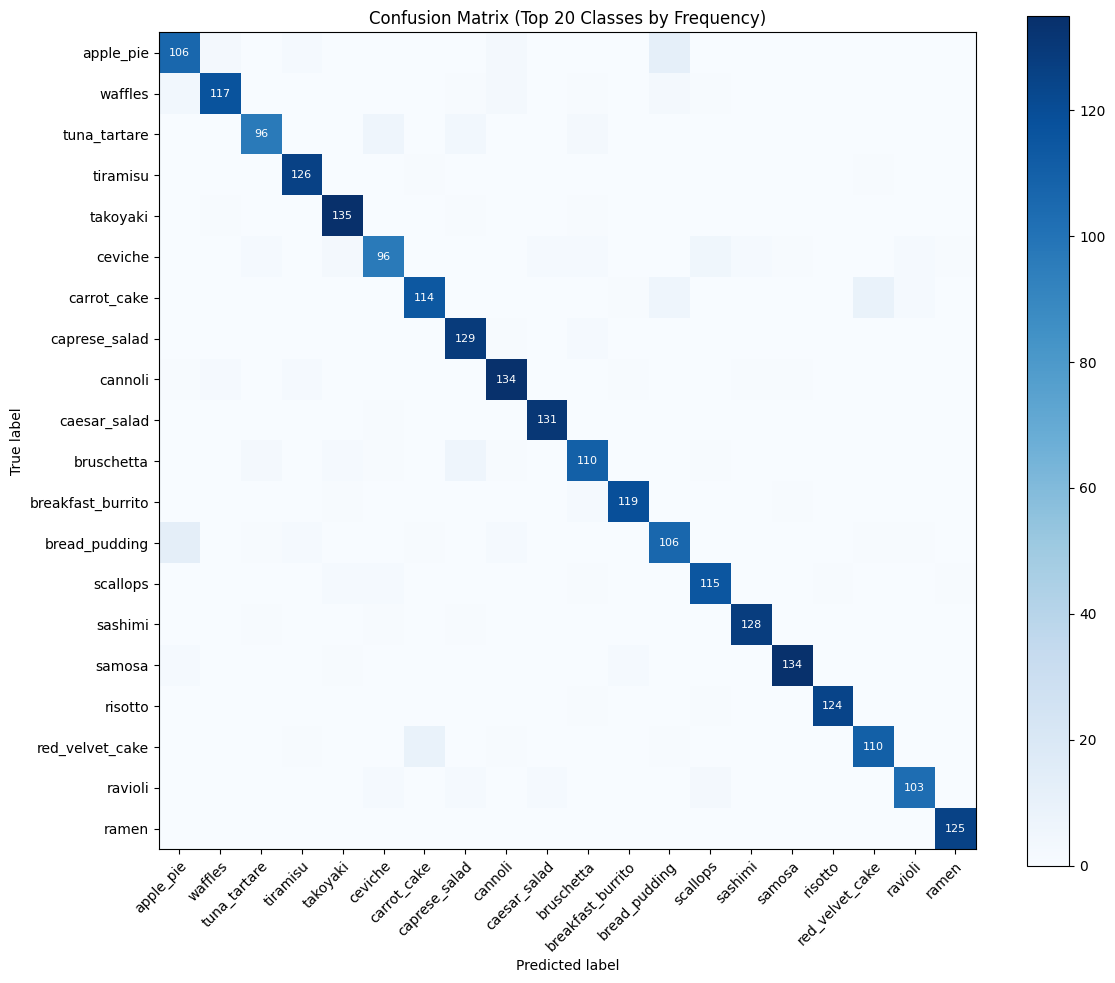

✓ Confusion matrix visualization saved as 'confusion_matrix_top20.png'

Confusion Matrix Statistics:
  Mean per-class accuracy: 0.834
  Std per-class accuracy:  0.101
  Min per-class accuracy:  0.467
  Max per-class accuracy:  0.980


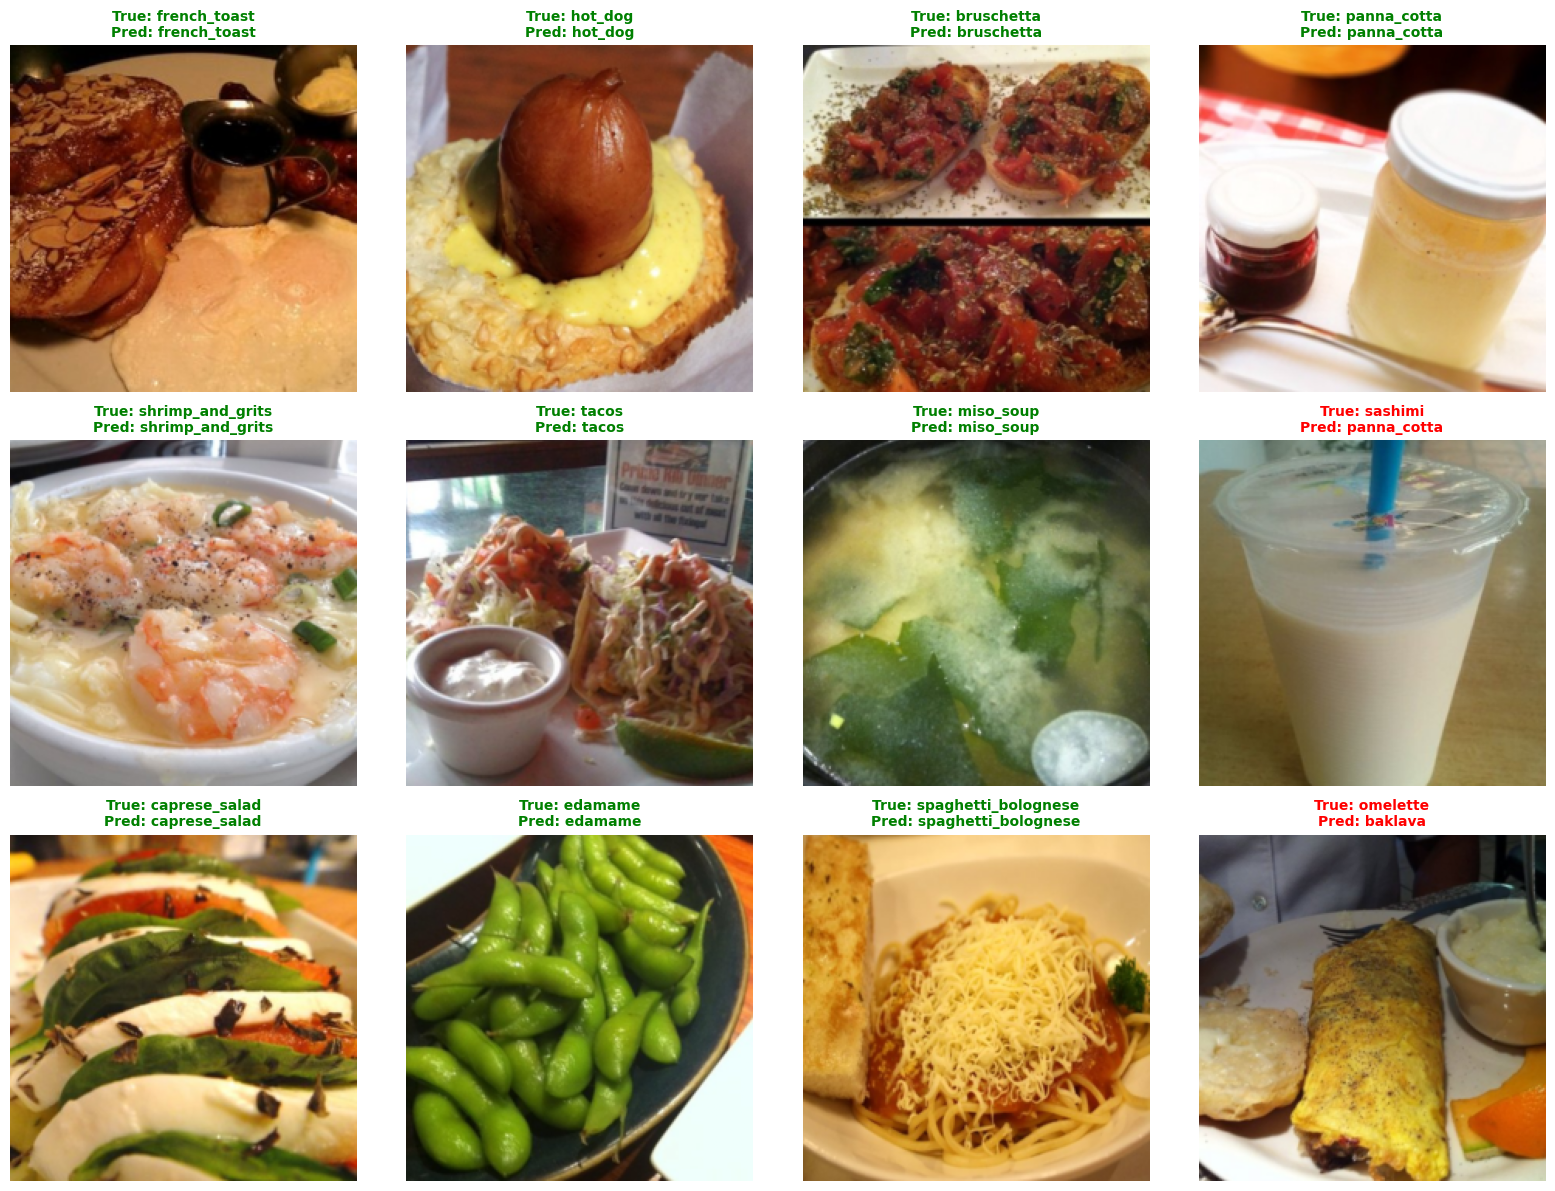

✓ Sample predictions saved as 'sample_predictions.png'

EVALUATION COMPLETE!

Generated files:
  1. best_vit_food_model.pth - Best model checkpoint
  2. training_history.png - Training curves
  3. classification_report.txt - Detailed per-class metrics
  4. confusion_matrix.npy - Full confusion matrix
  5. confusion_matrix_top20.png - Confusion matrix visualization
  6. sample_predictions.png - Sample predictions with ground truth


In [34]:
# Cell 30: Generate and visualize confusion matrix
print("\nGenerating confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Save confusion matrix as numpy array
np.save('confusion_matrix.npy', cm)
print("✓ Confusion matrix saved as 'confusion_matrix.npy'")

# Calculate per-class accuracy from confusion matrix
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot confusion matrix (heatmap of subset for visualization)
fig, ax = plt.subplots(figsize=(12, 10))

# For 101 classes, show a subset or aggregated view
# Here we'll show the top 20 classes by frequency
top_20_classes = np.argsort(cm.sum(axis=1))[-20:][::-1]

cm_subset = cm[top_20_classes][:, top_20_classes]
class_names_subset = [id2label[i] for i in top_20_classes]

im = ax.imshow(cm_subset, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Set ticks
ax.set(xticks=np.arange(cm_subset.shape[1]),
       yticks=np.arange(cm_subset.shape[0]),
       xticklabels=class_names_subset,
       yticklabels=class_names_subset,
       title='Confusion Matrix (Top 20 Classes by Frequency)',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations for high values
thresh = cm_subset.max() / 2.
for i in range(cm_subset.shape[0]):
    for j in range(cm_subset.shape[1]):
        if cm_subset[i, j] > thresh * 0.5:  # Only show significant values
            ax.text(j, i, format(cm_subset[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm_subset[i, j] > thresh else "black",
                   fontsize=8)

plt.tight_layout()
plt.savefig('confusion_matrix_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix visualization saved as 'confusion_matrix_top20.png'")

# Print overall statistics
print(f"\nConfusion Matrix Statistics:")
print(f"  Mean per-class accuracy: {per_class_accuracy.mean():.3f}")
print(f"  Std per-class accuracy:  {per_class_accuracy.std():.3f}")
print(f"  Min per-class accuracy:  {per_class_accuracy.min():.3f}")
print(f"  Max per-class accuracy:  {per_class_accuracy.max():.3f}")


# Cell 31: Sample predictions visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Get a batch from test set
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=test_images)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Move back to CPU for visualization
test_images = test_images.cpu()
predictions = predictions.cpu()

# Visualize 12 samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx in range(12):
    # Denormalize image
    img = denormalize(test_images[idx])
    img = img.permute(1, 2, 0).numpy()
    
    # Get labels
    true_label = id2label[test_labels[idx].item()]
    pred_label = id2label[predictions[idx].item()]
    
    # Determine color (green if correct, red if wrong)
    color = 'green' if true_label == pred_label else 'red'
    
    # Plot
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f"True: {true_label}\nPred: {pred_label}",
        color=color,
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample predictions saved as 'sample_predictions.png'")
print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  1. best_vit_food_model.pth - Best model checkpoint")
print("  2. training_history.png - Training curves")
print("  3. classification_report.txt - Detailed per-class metrics")
print("  4. confusion_matrix.npy - Full confusion matrix")
print("  5. confusion_matrix_top20.png - Confusion matrix visualization")
print("  6. sample_predictions.png - Sample predictions with ground truth")
print("="*60)